# Task 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import tsfel

%config InlineBackend.figure_format = 'retina'

**1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? *[0.5 marks]***

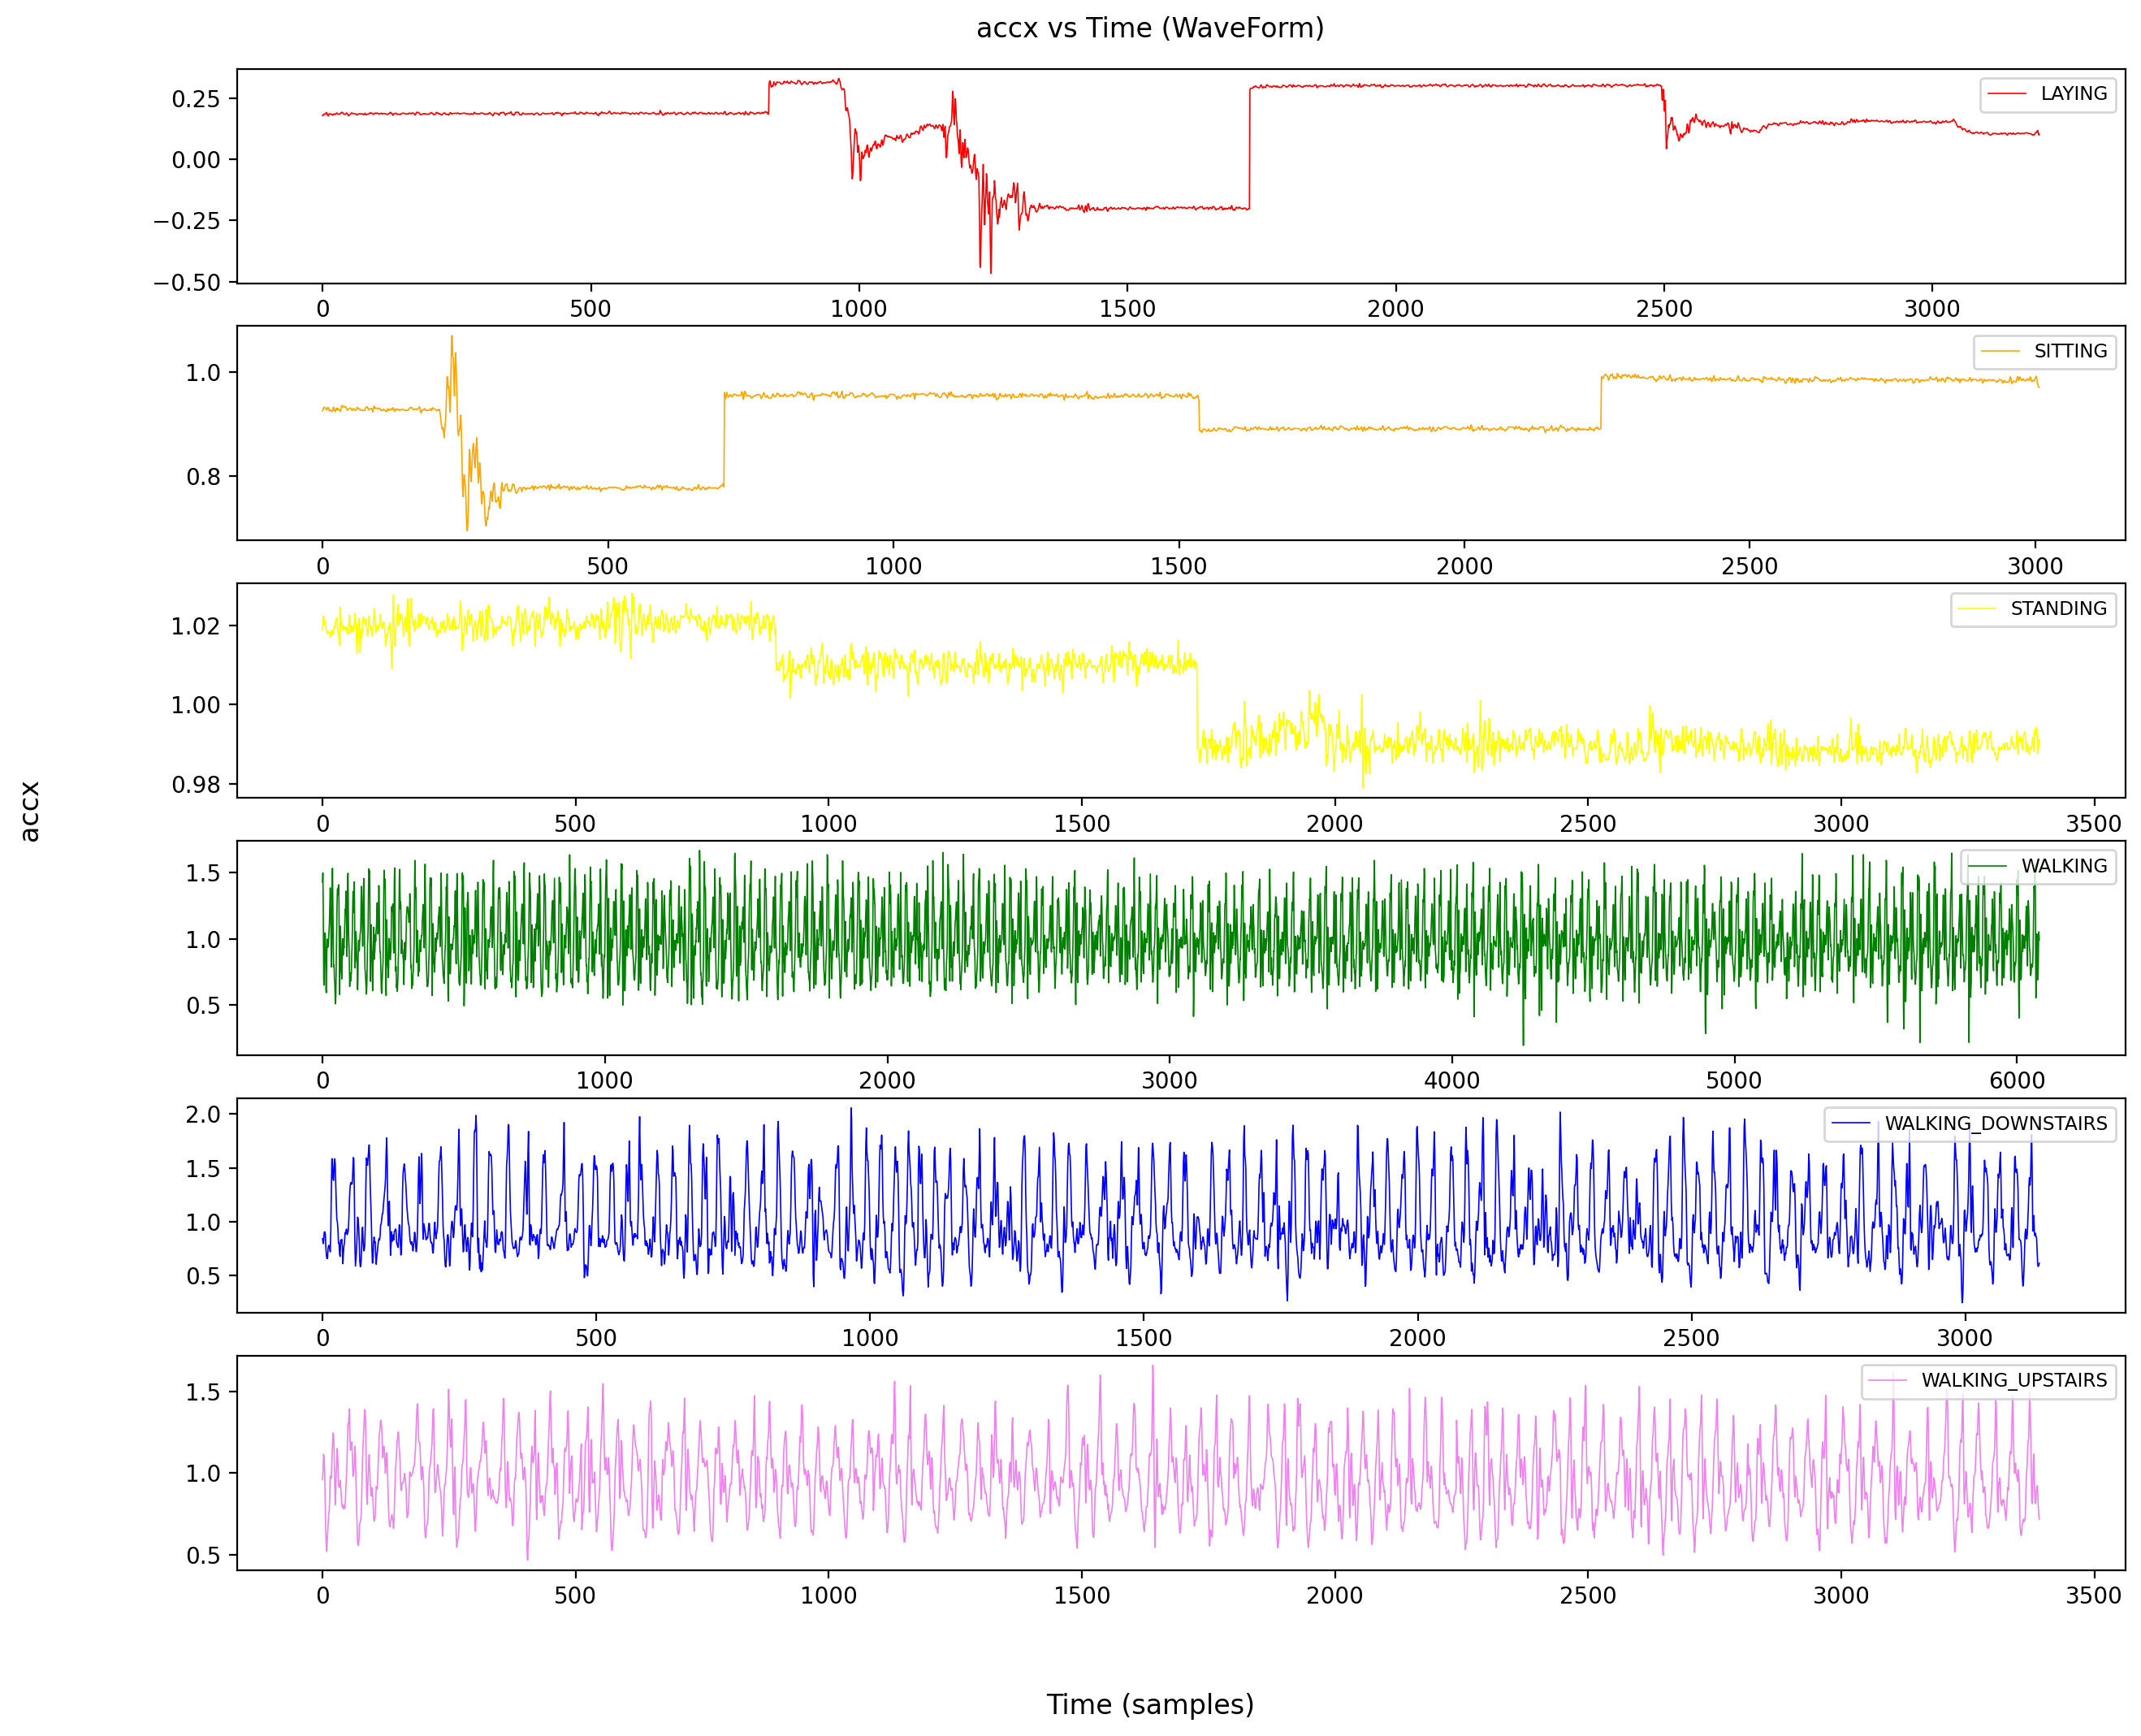

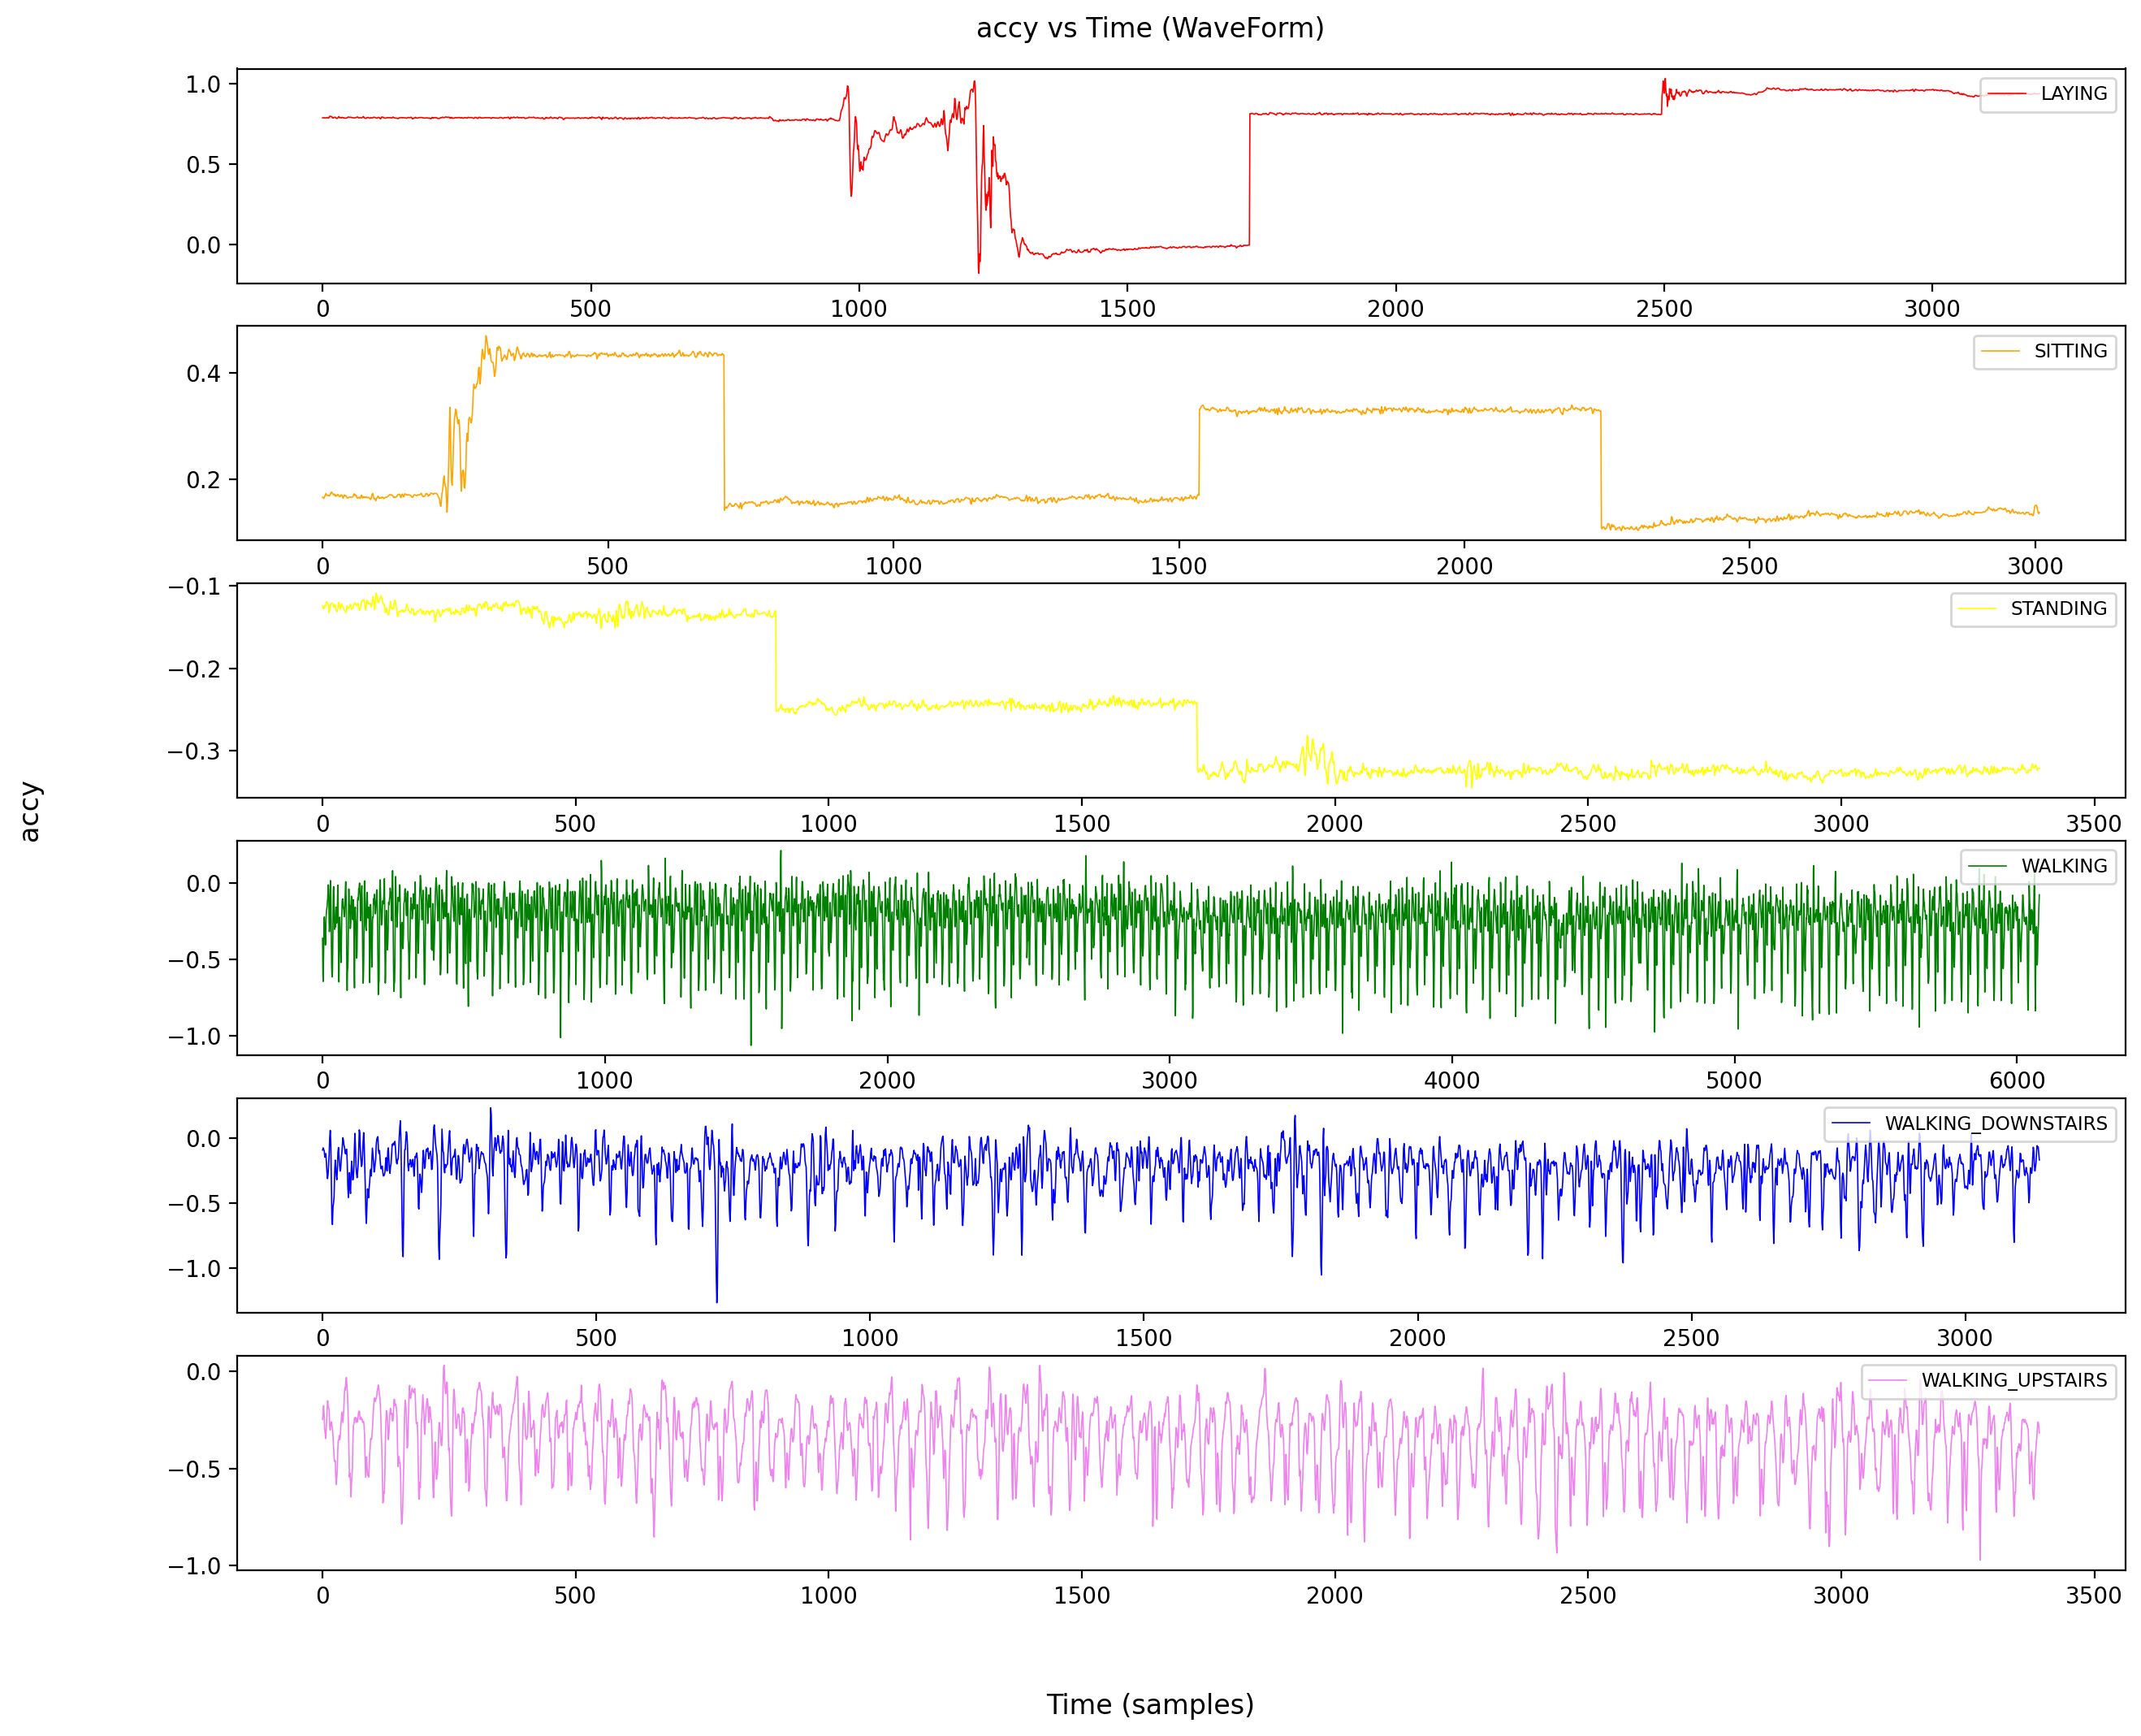

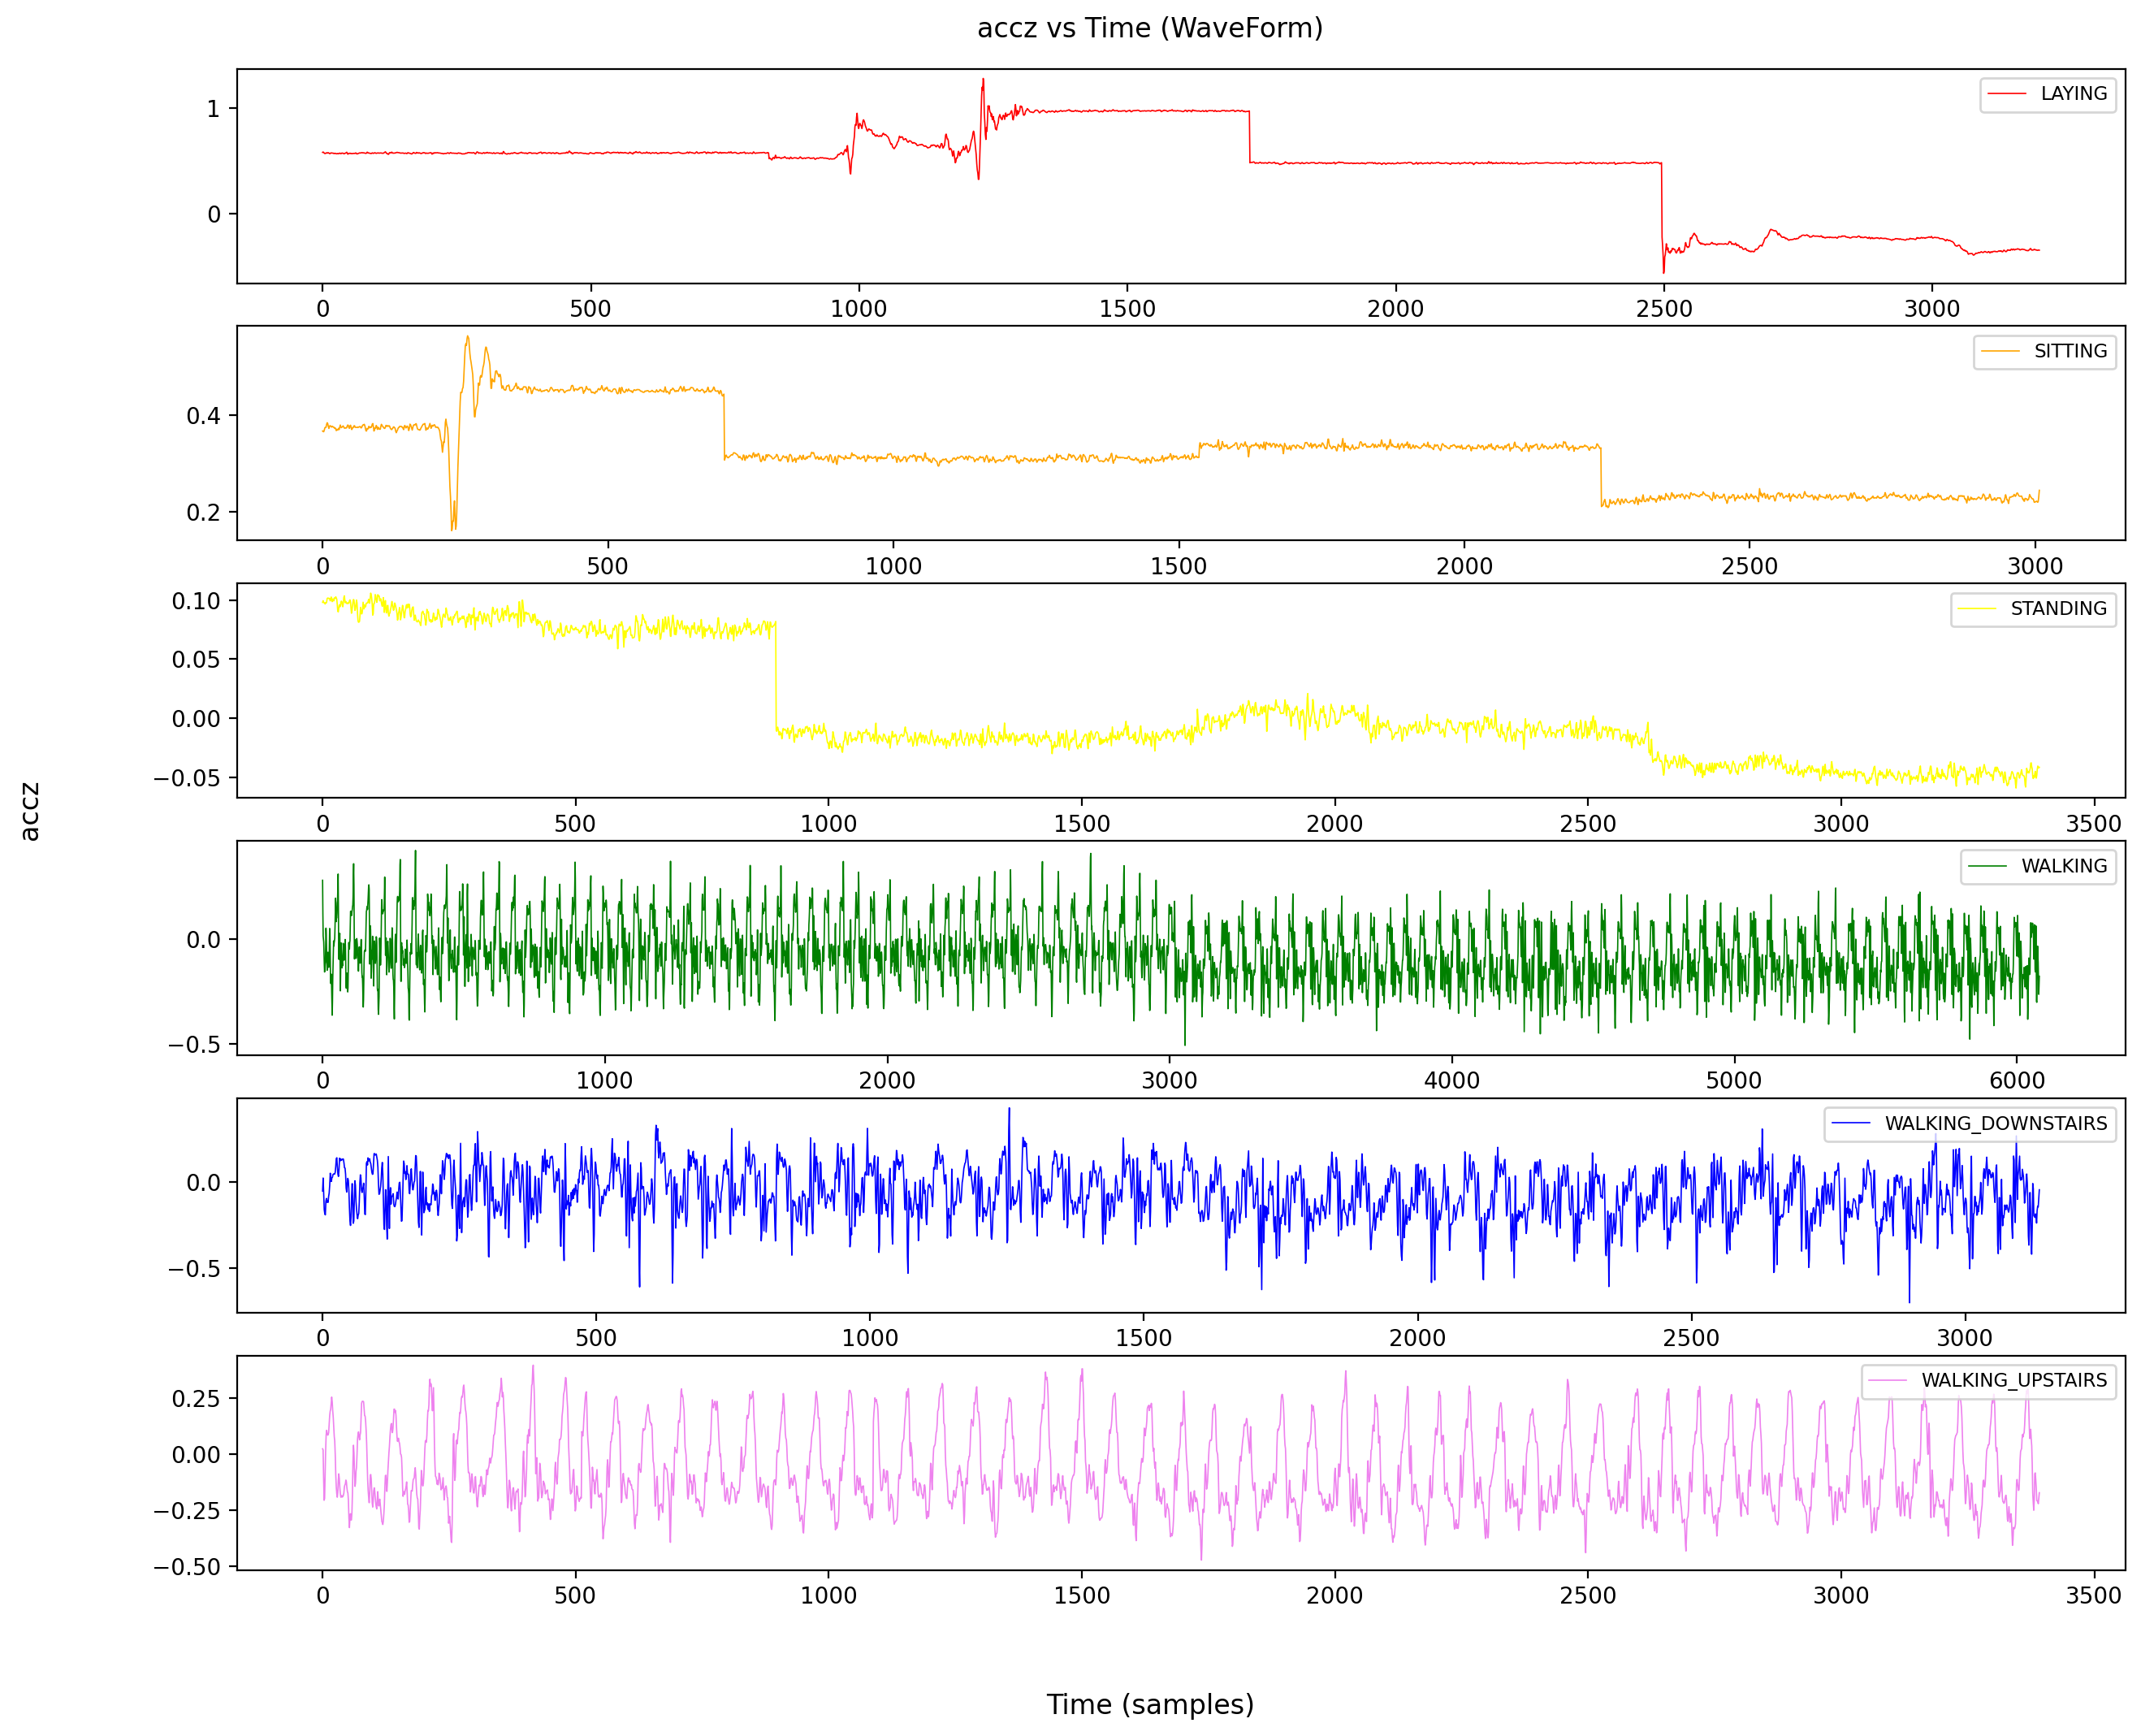

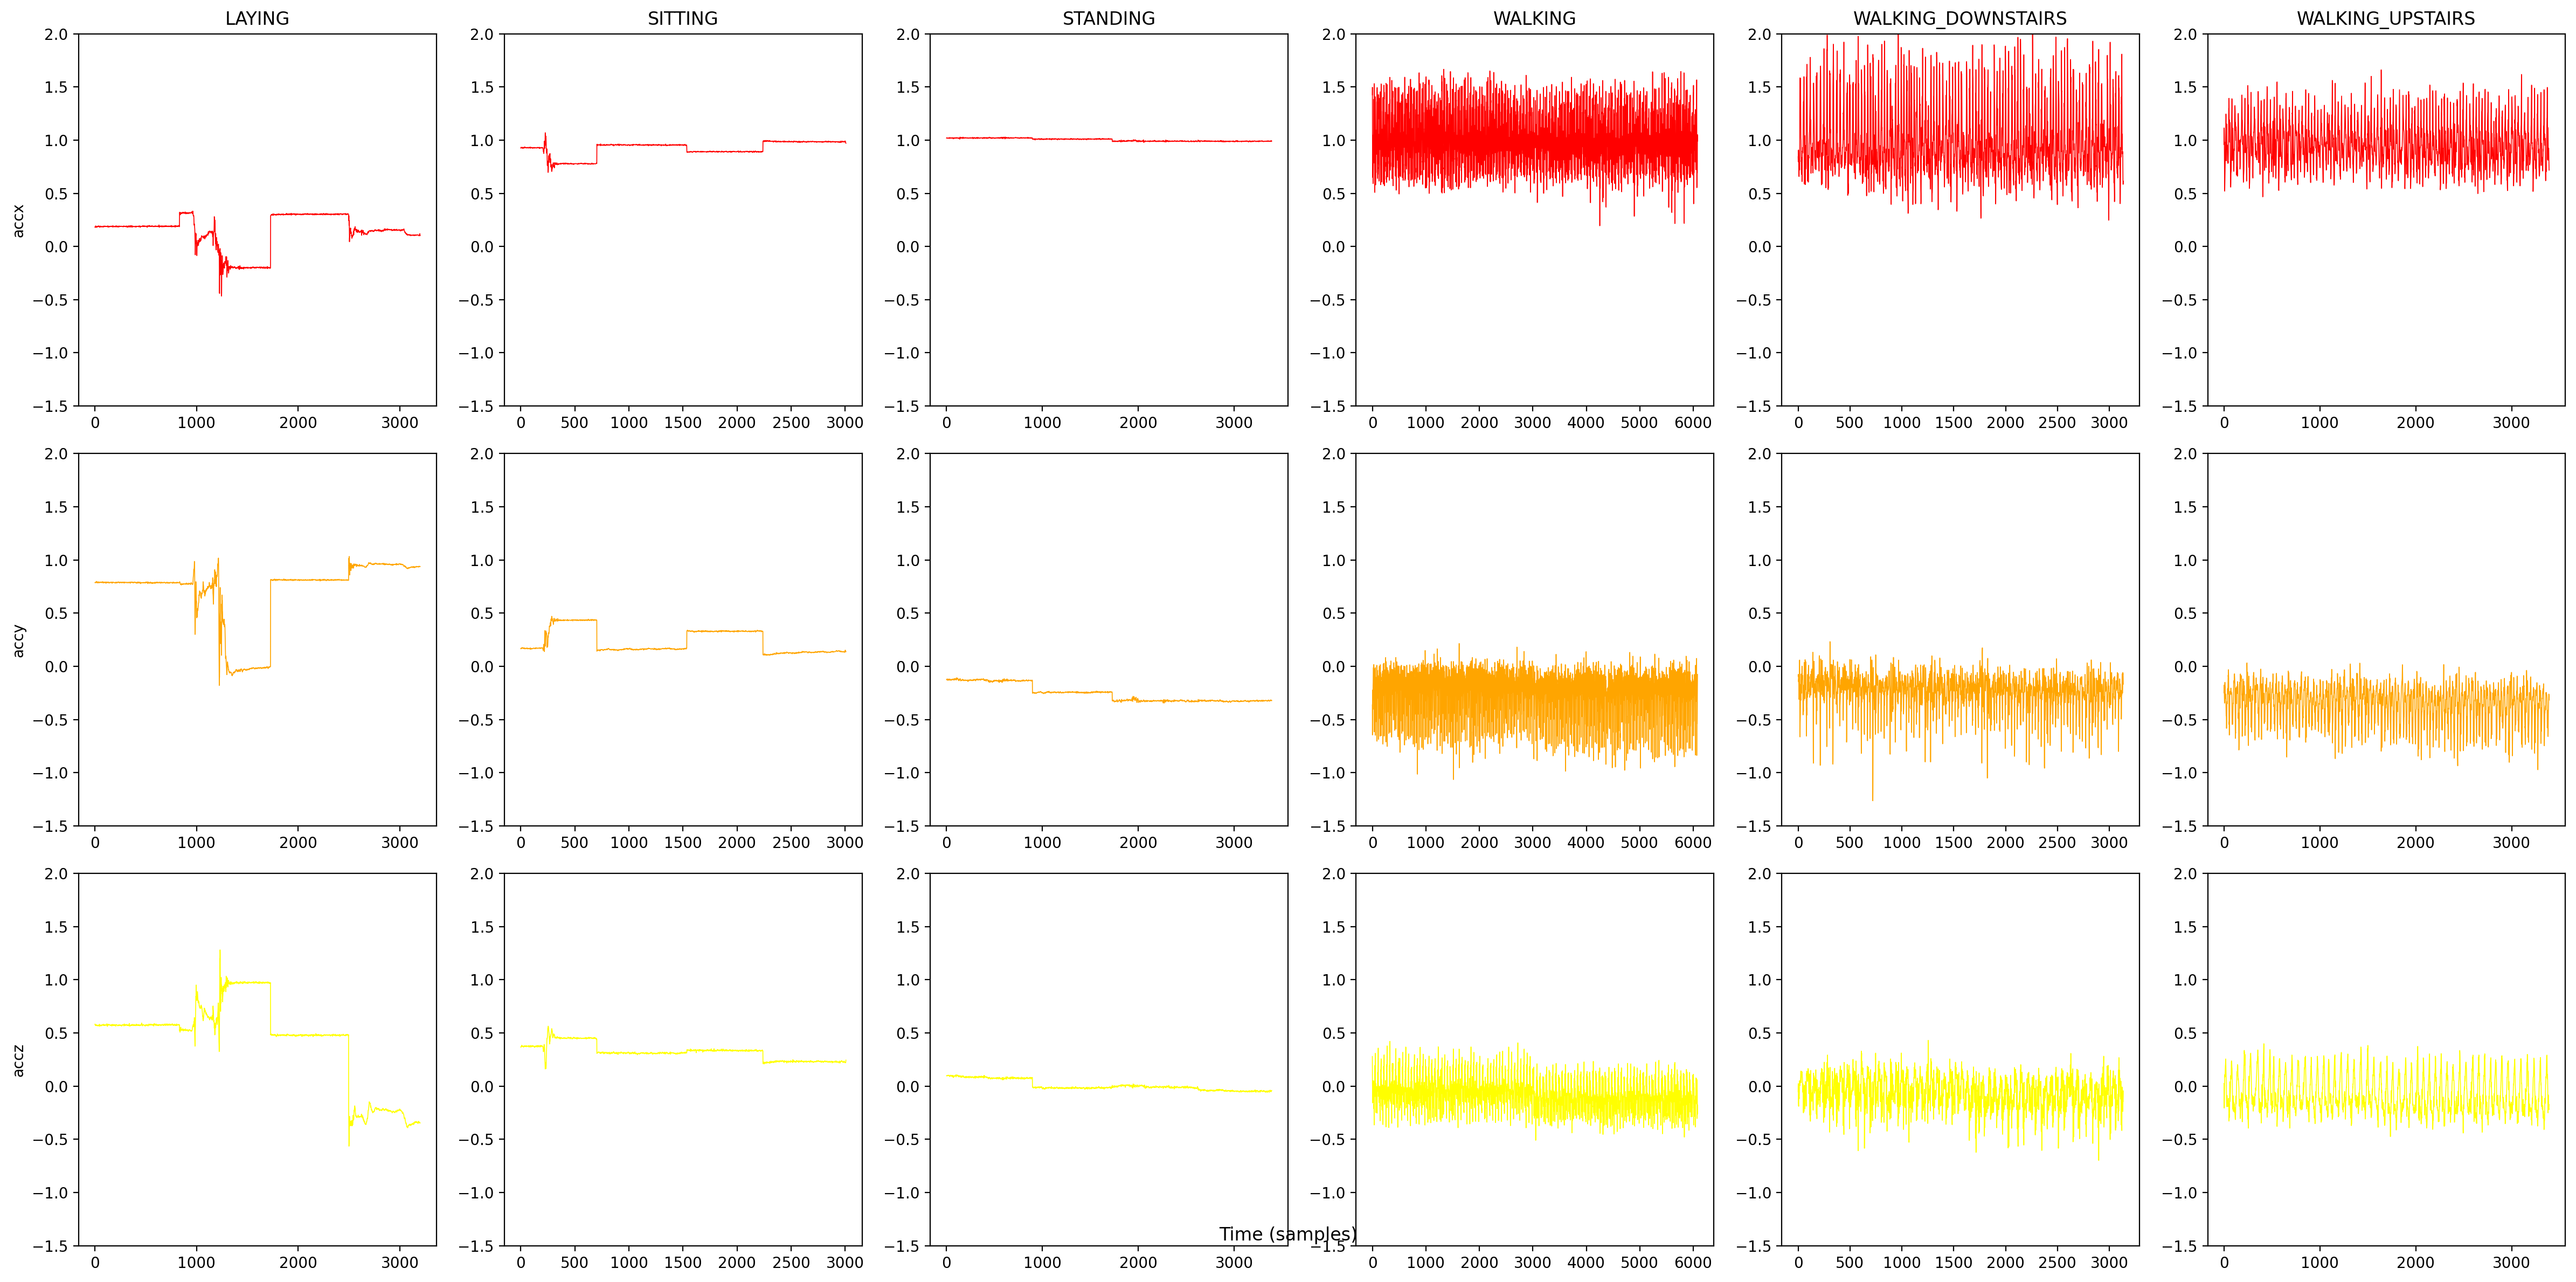

In [2]:
activities = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
axes = ['accx', 'accy', 'accz']

dfs = []
for act in activities:
    dfs.append(
        pd.read_csv(os.path.join("HAR", "Combined", "Train", act, "subject_1.csv"))
    )

# Individual and Enlarged Plots
for j, axis in enumerate(axes):
    fig, ax = plt.subplots(nrows = 6, figsize = (15, 12))
    for i, (df, label, color) in enumerate(zip(dfs, activities, colors)):
        ax[i].plot(df[axis], label = label, color = color, lw = 0.6)
        ax[i].legend(loc = 'upper right', fontsize = 'small')
    fig.text(0.04, 0.5, f'{axis}', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 12)
    fig.text(0.5, 0.04, 'Time (samples)', va = 'center', ha = 'center', fontsize = 12)
    fig.text(0.5, 0.9, f'{axis} vs Time (WaveForm)', va = 'center', ha = 'center', fontsize = 12)
    plt.show()

# All plots in a 3*6 grid
fig, ax = plt.subplots(3, 6, figsize = (24, 12))
for i, (df, label) in enumerate(zip(dfs, activities)):
    for j, axis in enumerate(axes):
        ax[j, i].plot(df[axis], label = label, lw = 0.6, color = colors[j])
        ax[j, i].set_ylim([-1.5, 2.0])
    ax[0, i].set_title(label)
ax[0, 0].set_ylabel('accx')
ax[1, 0].set_ylabel('accy')
ax[2, 0].set_ylabel('accz')
fig.text(0.5, 0.04, 'Time (samples)', va = 'center', ha = 'center', fontsize = 12)
# ax[:, 0].set_ylabel(axes)
plt.tight_layout()
plt.show()



**Conclusion:** It is definitely possible for the model to classify between laying, sitting, standing, and walking. As those actions have clearly distinguishable pattern in accx, accy, and accz. Classifying between walking normally, downstairs and upstairs might pose a challenge, though there are some feature that distinguish them too.

**2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration ($acc_x^2+acc_y^2+acc_z^2$) for each activity and justify your answer. *[0.5 marks]***

In [ ]:
las = [(df['accx']**2 + df['accy']**2 + df['accz']**2) for df in dfs]

fig, ax = plt.subplots(nrows = 6, figsize = (15, 15))

for i, (la, label, color) in enumerate(zip(las, activities, colors)):
    ax[i].plot(la, label = label, lw = 0.6, color = color)
    ax[i].legend(loc = 'upper right', fontsize = 'small')

fig.text(0.04, 0.5, '$acc_x^2+acc_y^2+acc_z^2$', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 12)
fig.text(0.5, 0.04, 'Time (samples)', va = 'center', ha = 'center', fontsize = 12)
fig.text(0.5, 0.9, f'Linear Accelerations vs Time (WaveForm)', va = 'center', ha = 'center', fontsize = 12)
plt.show()

**Conclusion:** From the above graphs, it is clear that distinction between static and dynamic can be made by observing flutuations in the linear acceleration. But we need ML models for to detect and distinguish between the subclasses.

**3.Visualize the data using PCA. *[1 marks]***

- **Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.**

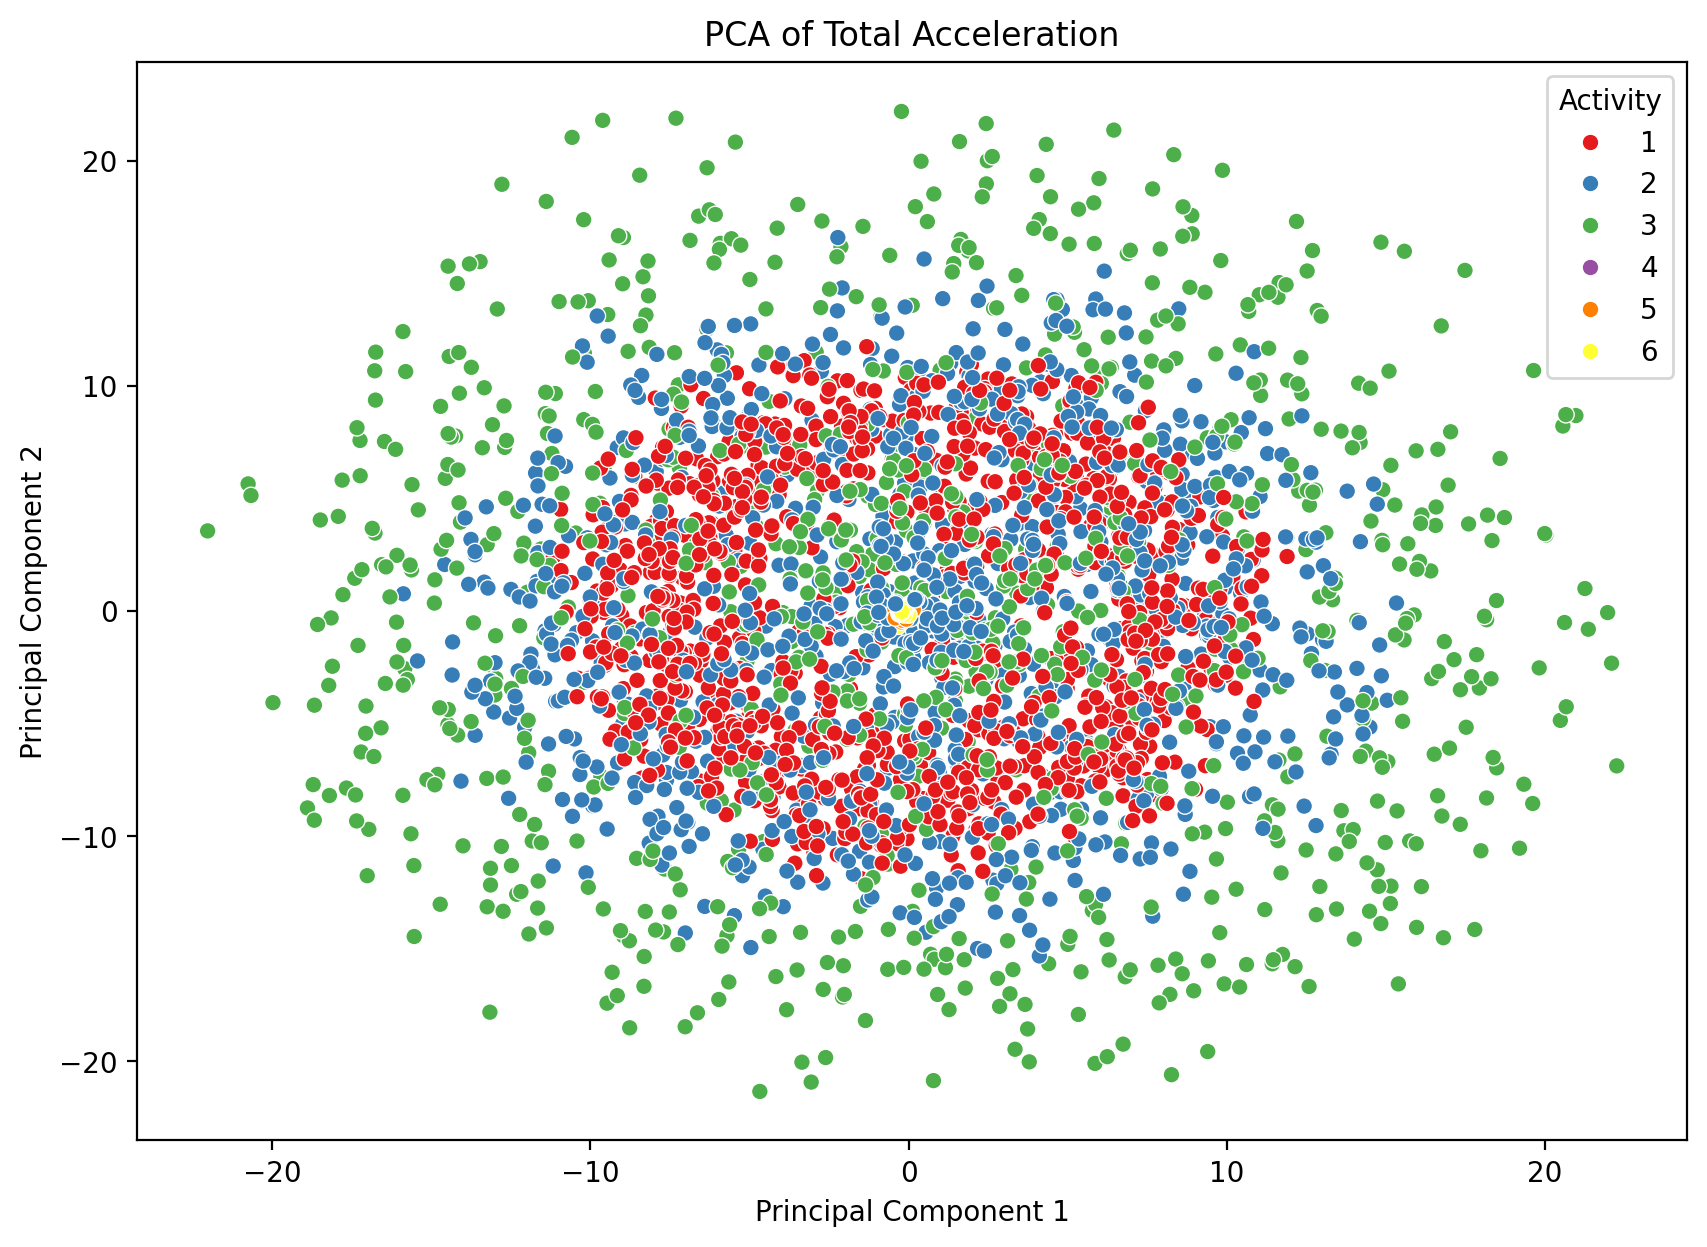

In [3]:
root = os.path.join("HAR", "UCI HAR Dataset", "train")
total_acc_x = pd.read_csv(os.path.join(root, "Inertial Signals", "total_acc_x_train.txt"), sep='\s+', header=None)
total_acc_y = pd.read_csv(os.path.join(root, "Inertial Signals", "total_acc_y_train.txt"), sep='\s+', header=None)
total_acc_z = pd.read_csv(os.path.join(root, "Inertial Signals", "total_acc_z_train.txt"), sep='\s+', header=None)
y_train_df = pd.read_csv(os.path.join(root, "y_train.txt"), header=None)
X_train_df = total_acc_x**2 + total_acc_y**2 + total_acc_z**2

# Standardize the data
scaler = StandardScaler()
std_X = scaler.fit_transform(X_train_df)

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(std_X)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Activity'] = y_train_df

# Step 3: Plot the results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='Activity', palette='Set1')
plt.title('PCA of Total Acceleration')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.show()

- **Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.**

In [5]:
from HAR.MakeDataset import X_train, y_train
# X_train = pd.read_csv(os.path.join("HAR", "UCI HAR Dataset", "train", "X_train.txt"), sep='\s+', header=None)

# Initialize tsfel feature configuration
cfg = tsfel.get_features_by_domain()
tsfel_features = []

# extact all features
for sample in X_train:
    sample_features = tsfel.time_series_features_extractor(cfg, sample)
    tsfel_features.append(sample_features.values.flatten())

*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***
*** Feature extraction started ***


/tmp/ipykernel_109340/2846629937.py:10: UserWarning: Using default sampling frequency set in configuration file.
  sample_features = tsfel.time_series_features_extractor(cfg, sample)



*** Feature extraction finished ***


In [16]:
tsfel_features_df = tsfel_features = pd.DataFrame(np.array(tsfel_features))
print("Shape after extracting all features:", tsfel_features_df.shape)

# Remove features that are highly related
correlation_threshold = 0.9
corr_matrix = tsfel_features_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column]>correlation_threshold)]
tsfel_features_df = tsfel_features_df.drop(to_drop, axis = 1)
print("Shape after removing highly correlated features:", tsfel_features_df.shape)

# Remove features with low variance
selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
selector.fit(tsfel_features_df)
features_to_keep = selector.get_support(indices = True)
tsfel_features_df = tsfel_features_df.iloc[:, features_to_keep]
print("Shape after removing features with low variance:", tsfel_features_df.shape)

Shape after extracting all features: (126, 1152)
Shape after removing highly correlated features: (126, 796)
Shape after removing features with low variance: (126, 97)


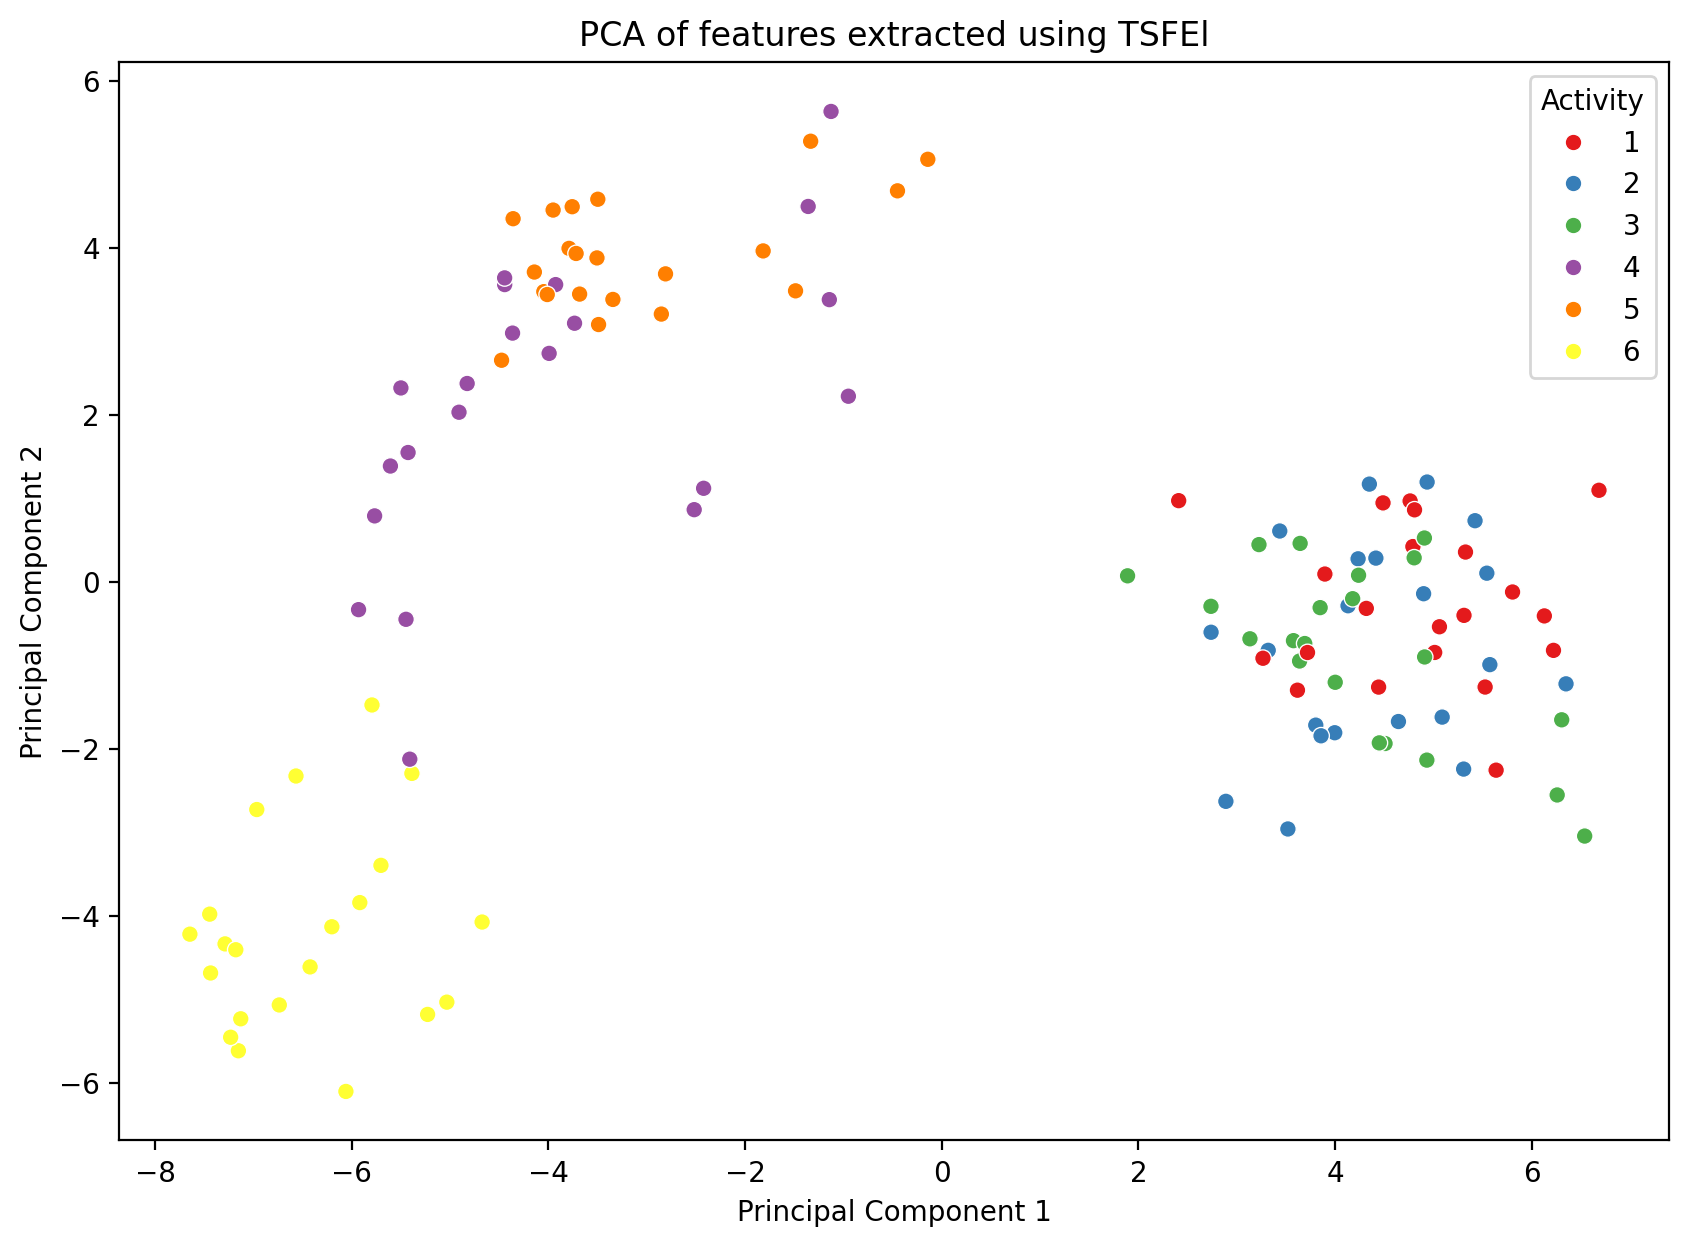

In [14]:
tsfel_std = scaler.fit_transform(tsfel_features_df)

principal_components_1 = pca.fit_transform(tsfel_std)
principal_df_1 = pd.DataFrame(data=principal_components_1, columns=['PC1', 'PC2'])
principal_df_1['Activity'] = y_train

# Step 3: Plot the results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=principal_df_1, x='PC1', y='PC2', hue='Activity', palette='Set1')
plt.title('PCA of features extracted using TSFEl')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.show()

- **Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.**

In [11]:
features_file = pd.read_csv(os.path.join("HAR", "UCI HAR Dataset", "features.txt"), sep='\s+', header=None)
features = pd.Series(features_file[1].tolist())

duplicates = features[features.duplicated()].unique()

for dup in duplicates:
    dup_indices = features[features == dup].index
    for i, idx in enumerate(dup_indices):
        features[idx] = f"{dup}.{i+1}"

X_train_data = pd.read_csv(os.path.join("HAR", "UCI HAR Dataset", "train", "X_train.txt"), sep='\s+', header=None, names=features)
# i have y_train_df from before 
print(f"X_train shape: {X_train_data.shape}")
print(f"y_train shape: {y_train_df.shape}")

X_train shape: (7352, 561)
y_train shape: (7352, 1)


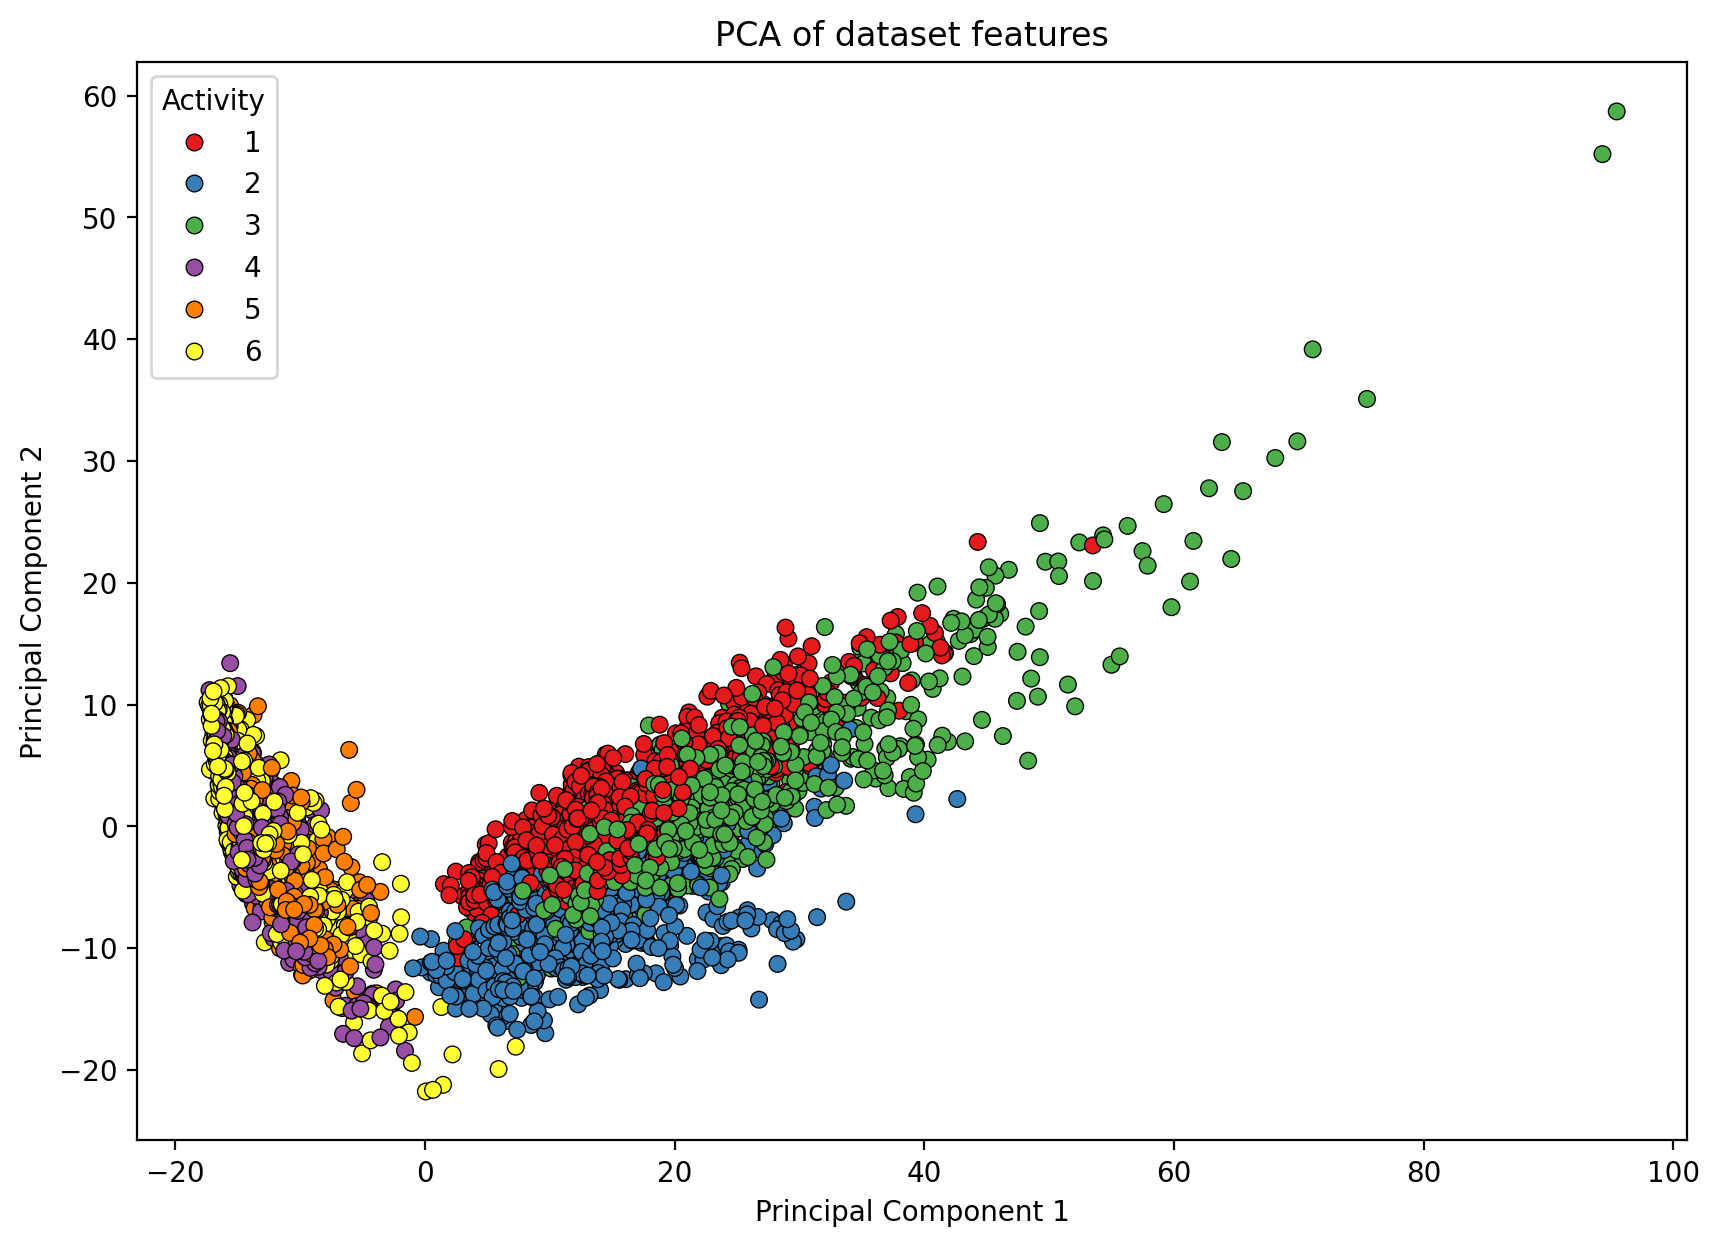

In [15]:
# perform PCA
X_std = scaler.fit_transform(X_train_data)

principal_components_2 = pca.fit_transform(X_std)
principal_df_2 = pd.DataFrame(data=principal_components_2, columns=['PC1', 'PC2'])
principal_df_2['Activity'] = y_train_df

# Step 3: Plot the results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=principal_df_2, x='PC1', y='PC2', hue='Activity', palette='Set1', edgecolor = 'black')
plt.title('PCA of dataset features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity')
plt.show()

- **Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?**

**4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? *[1 marks]***

In [17]:
tsfel_corr = tsfel_features.corr();
dataset_corr = X_train_data.corr();

def get_redundant(corr_matrix, threshold):
    redundant_features = set()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold:
                redundant_features.add( corr_matrix.columns[i])
                
    return redundant_features

ts = 0.9

tsfel_redundant = get_redundant(tsfel_corr, ts)
dataset_redundant = get_redundant(dataset_corr, ts)

print(f"Number of redundant features provided by tsfel and dataset are {len(tsfel_redundant)} and {len(dataset_redundant)} respectively.")

Number of redundant features provided by tsfel and dataset are 356 and 359 respectively.


In [18]:
tsfel_corr

0         1         2         3         4     5     6         7     \
0     1.000000  0.983795 -0.264541  1.000000  0.164905   NaN   NaN  0.876788   
1     0.983795  1.000000 -0.209707  0.983795  0.188140   NaN   NaN  0.930703   
2    -0.264541 -0.209707  1.000000 -0.264541 -0.250115   NaN   NaN -0.168205   
3     1.000000  0.983795 -0.264541  1.000000  0.164905   NaN   NaN  0.876788   
4     0.164905  0.188140 -0.250115  0.164905  1.000000   NaN   NaN  0.171760   
...        ...       ...       ...       ...       ...   ...   ...       ...   
1147  0.258657  0.223288 -0.189271  0.258657  0.061713   NaN   NaN  0.023610   
1148  0.250138  0.216489 -0.188815  0.250138  0.063024   NaN   NaN  0.015469   
1149  0.240642  0.206371 -0.188071  0.240642  0.064724   NaN   NaN  0.000259   
1150  0.223981  0.187596 -0.182592  0.223981  0.064801   NaN   NaN -0.022849   
1151  0.468866  0.376123 -0.238780  0.468866  0.046532   NaN   NaN  0.148931   

          8     9     ...      1142      1143      1144      1145      1146  \
0     0.972869   NaN  ...  0.345805  0.337745  0.321384  0.292348  0.271467   
1     0.955381   NaN  ...  0.275828  0.275300  0.263659  0.244440  0.231504   
2    -0.244005   NaN  ... -0.202415 -0.202285 -0.203462 -0.197199 -0.192017   
3     0.972869   NaN  ...  0.345805  0.337745  0.321384  0.292348  0.271467   
4     0.157979   NaN  ...  0.056745  0.056844  0.061027  0.062885  0.062050   
...        ...   ...  ...       ...       ...       ...       ...       ...   
1147  0.357024   NaN  ...  0.614382  0.717531  0.859823  0.955517  0.992761   
1148  0.350563   NaN  ...  0.587850  0.684352  0.826038  0.928373  0.975069   
1149  0.342778   NaN  ...  0.558526  0.644431  0.783368  0.884874  0.935287   
1150  0.325667   NaN  ...  0.508801  0.576700  0.707341  0.801309  0.851650   
1151  0.514148   NaN  ...  0.677158  0.564028  0.425861  0.305619  0.244438   

          1147      1148      1149      1150      1151  
0     0.258657  0.250138  0.240642  0.223981  0.468866  
1     0.223288  0.216489  0.206371  0.187596  0.376123  
2    -0.189271 -0.188815 -0.188071 -0.182592 -0.238780  
3     0.258657  0.250138  0.240642  0.223981  0.468866  
4     0.061713  0.063024  0.064724  0.064801  0.046532  
...        ...       ...       ...       ...       ...  
1147  1.000000  0.993195  0.963140  0.888644  0.215177  
1148  0.993195  1.000000  0.987182  0.932467  0.205033  
1149  0.963140  0.987182  1.000000  0.977729  0.211060  
1150  0.888644  0.932467  0.977729  1.000000  0.229717  
1151  0.215177  0.205033  0.211060  0.229717  1.000000  

[1152 rows x 1152 columns]

In [19]:
dataset_corr

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  \
tBodyAcc-mean()-X                              1.000000           0.148061   
tBodyAcc-mean()-Y                              0.148061           1.000000   
tBodyAcc-mean()-Z                             -0.256952          -0.078769   
tBodyAcc-std()-X                               0.000619          -0.045160   
tBodyAcc-std()-Y                              -0.021903          -0.044920   
...                                                 ...                ...   
angle(tBodyGyroMean,gravityMean)               0.037444           0.017967   
angle(tBodyGyroJerkMean,gravityMean)           0.028844           0.075679   
angle(X,gravityMean)                          -0.035257          -0.005309   
angle(Y,gravityMean)                           0.034371           0.001053   
angle(Z,gravityMean)                           0.028242          -0.013903   

                                      tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
tBodyAcc-mean()-X                             -0.256952          0.000619   
tBodyAcc-mean()-Y                             -0.078769         -0.045160   
tBodyAcc-mean()-Z                              1.000000         -0.020217   
tBodyAcc-std()-X                              -0.020217          1.000000   
tBodyAcc-std()-Y                              -0.016641          0.927461   
...                                                 ...               ...   
angle(tBodyGyroMean,gravityMean)              -0.063609          0.018985   
angle(tBodyGyroJerkMean,gravityMean)          -0.034037         -0.024810   
angle(X,gravityMean)                           0.008587         -0.371653   
angle(Y,gravityMean)                          -0.015288          0.471065   
angle(Z,gravityMean)                          -0.022643          0.394825   

                                      tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
tBodyAcc-mean()-X                            -0.021903         -0.044617   
tBodyAcc-mean()-Y                            -0.044920         -0.049746   
tBodyAcc-mean()-Z                            -0.016641         -0.008410   
tBodyAcc-std()-X                              0.927461          0.851668   
tBodyAcc-std()-Y                              1.000000          0.895510   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)             -0.008507         -0.018429   
angle(tBodyGyroJerkMean,gravityMean)         -0.014592         -0.006471   
angle(X,gravityMean)                         -0.380531         -0.345011   
angle(Y,gravityMean)                          0.523600          0.476006   
angle(Z,gravityMean)                          0.433169          0.482828   

                                      tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
tBodyAcc-mean()-X                             0.006290         -0.022754   
tBodyAcc-mean()-Y                            -0.044180         -0.045049   
tBodyAcc-mean()-Z                            -0.018747         -0.015203   
tBodyAcc-std()-X                              0.998632          0.920888   
tBodyAcc-std()-Y                              0.922803          0.997347   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)              0.019389         -0.012546   
angle(tBodyGyroJerkMean,gravityMean)         -0.024951         -0.012341   
angle(X,gravityMean)                         -0.368191         -0.377025   
angle(Y,gravityMean)                          0.466424          0.525081   
angle(Z,gravityMean)                          0.390922          0.431459   

                                      tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
tBodyAcc-mean()-X                            -0.047558          0.044062  ...   
tBodyAcc-mean()-Y                            -0.050402         -0.038108  ...   
tBodyAcc-mean()-Z                            -0.001988         -0.037197  ...   
tBodyAcc-std()-X          